In [11]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, UnidentifiedImageError
import hashlib
from collections import defaultdict
from tqdm import tqdm

In [12]:
# Set path to your dataset directory
DATASET_PATH = 'C:\\Users\\Specter\\Desktop\\Friontier ML training\\capstone_project\\code\\data\\PlantVillage'

In [4]:
# Load dataset information
image_data = []
for label in os.listdir(DATASET_PATH):
    class_path = os.path.join(DATASET_PATH, label)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            image_data.append({'label': label, 'path': img_path})

# Convert to DataFrame
df = pd.DataFrame(image_data)

In [5]:
df['label'].value_counts()

label
Tomato__Tomato_YellowLeaf__Curl_Virus          3208
Tomato_Bacterial_spot                          2127
Tomato_Late_blight                             1909
Tomato_Septoria_leaf_spot                      1771
Tomato_Spider_mites_Two_spotted_spider_mite    1676
Tomato_healthy                                 1591
Pepper__bell___healthy                         1478
Tomato__Target_Spot                            1404
Potato___Early_blight                          1000
Potato___Late_blight                           1000
Tomato_Early_blight                            1000
Pepper__bell___Bacterial_spot                   997
Tomato_Leaf_Mold                                952
Tomato__Tomato_mosaic_virus                     373
Potato___healthy                                152
PlantVillage                                     15
Name: count, dtype: int64

In [6]:
df.columns

Index(['label', 'path'], dtype='object')

In [7]:
# Drop rows where the value in the 'label' column is 'PlantVillage'
df1 = df[df['label'] != 'PlantVillage']

In [10]:
# Summary stats
print(f"Total images: {len(df1)}")
print(f"Total classes: {df1['label'].nunique()}")

Total images: 20638
Total classes: 15


In [11]:
# Set the path to your dataset
dataset_dir = 'C:\\Users\\Specter\\Desktop\\Friontier ML training\\capstone_project\\code\\data\\PlantVillage'
# Function to check if an image is corrupted (with PIL and OpenCV)
def is_image_corrupted(image_path):
    # Try using PIL
    try:
        with Image.open(image_path) as img:
            img.verify()
    except (UnidentifiedImageError, IOError, SyntaxError):
        return True
    # Try using OpenCV
    try:
        img_cv = cv2.imread(image_path)
        if img_cv is None:
            return True
    except Exception:
        return True
    return False

# Walk through dataset folders and clean
removed_images = 0
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        file_path = os.path.join(root, file)
        
        # Remove if it's a corrupted image
        if is_image_corrupted(file_path):
            print(f"Removing corrupted image: {file_path}")
            os.remove(file_path)
            removed_images += 1
            continue
        
        # Remove if it's missing a label (i.e., it's not in a class subfolder)
        rel_path = os.path.relpath(file_path, dataset_dir)
        if len(rel_path.split(os.sep)) < 2:
            print(f"Removing image with missing label: {file_path}")
            os.remove(file_path)
            removed_images += 1

print(f"\nCompleted cleaning. Total images removed: {removed_images}")


Completed cleaning. Total images removed: 0


### Identify Corrupted image

In [10]:
# Function to check if an image is corrupted
def is_image_corrupted(image_path):
    # Check with Pillow (PIL)
    try:
        with Image.open(image_path) as img:
            img.verify()
    except (UnidentifiedImageError, IOError, SyntaxError):
        return True
    # Check with OpenCV
    try:
        img_cv = cv2.imread(image_path)
        if img_cv is None:
            return True
    except Exception:
        return True
    return False

# Scan the dataset
corrupted_images = []
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        file_path = os.path.join(root, file)
        if is_image_corrupted(file_path):
            corrupted_images.append(file_path)

# Print results
if corrupted_images:
    print("⚠️ Corrupted images found:")
    for path in corrupted_images:
        print(path)
else:
    print("✅ No corrupted images found.")


✅ No corrupted images found.


In [12]:
# Part 1: Identify images with missing labels ----------
missing_label_images = []

for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        file_path = os.path.join(root, file)
        # Images with no subfolder label (e.g., directly in the root)
        relative_path = os.path.relpath(file_path, dataset_dir)
        if len(relative_path.split(os.sep)) < 2:
            missing_label_images.append(file_path)

In [13]:
print("\n🔍 Images with Missing Labels:")
if missing_label_images:
    for img in missing_label_images:
        print(img)
else:
    print("✅ No images with missing labels found.")



🔍 Images with Missing Labels:
✅ No images with missing labels found.


In [14]:
# Identify duplicate images 
def compute_md5(file_path):
    hasher = hashlib.md5()
    with open(file_path, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()

hash_map = defaultdict(list)

for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            file_hash = compute_md5(file_path)
            hash_map[file_hash].append(file_path)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

# Collect duplicates
duplicate_images = [paths for paths in hash_map.values() if len(paths) > 1]

In [15]:
print("\n🔍 Duplicate Images:")
if duplicate_images:
    for group in duplicate_images:
        print("\nDuplicate group:")
        for img in group:
            print(f" - {img}")
else:
    print("✅ No duplicate images found.")

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [19]:
# Thresholds (tweak if needed)
BLUR_THRESHOLD = 100.0        
DARKNESS_THRESHOLD = 50       
EDGE_DENSITY_THRESHOLD = 0.3  

# Storage
blurry_images = []
dark_images = []
busy_background_images = []

In [20]:
# Laplacian variance for blur detection
def is_blurry(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return lap_var < BLUR_THRESHOLD, lap_var

In [21]:
# Brightness detection
def is_dark(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    brightness = np.mean(hsv[:, :, 2])
    return brightness < DARKNESS_THRESHOLD, brightness

In [22]:
# Edge density check
def has_busy_background(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges > 0) / edges.size
    return edge_density > EDGE_DENSITY_THRESHOLD, edge_density

In [23]:
# Process images
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = cv2.imread(file_path)
            if img is None:
                continue

            blur_flag, blur_score = is_blurry(img)
            dark_flag, brightness = is_dark(img)
            busy_flag, edge_density = has_busy_background(img)

            if blur_flag:
                blurry_images.append((file_path, blur_score))
            if dark_flag:
                dark_images.append((file_path, brightness))
            if busy_flag:
                busy_background_images.append((file_path, edge_density))

        except Exception as e:
            print(f"Error processing {file_path}: {e}")


In [24]:
# --- Display Summary ---
print("\n🔍 Visual Noise Summary")
print(f"🔴 Blurry images detected: {len(blurry_images)}")
print(f"🌑 Dark images detected: {len(dark_images)}")
print(f"🎯 Images with busy backgrounds: {len(busy_background_images)}")


🔍 Visual Noise Summary
🔴 Blurry images detected: 1690
🌑 Dark images detected: 254
🎯 Images with busy backgrounds: 1772


In [25]:
# Function to show sample images
def show_samples(image_list, title):
    print(f"\n{title} Sample Images:")
    for idx, (path, score) in enumerate(image_list[:3]):  
        img = cv2.imread(path)
        if img is not None:
            display_text = f"{title}: {round(score, 2)}"
            cv2.putText(img, display_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                        1, (0, 255, 0), 2, cv2.LINE_AA)
            cv2.imshow(f"{title} {idx+1}", img)
            cv2.waitKey(2000)  
            cv2.destroyAllWindows()

In [18]:
# Show the samples
show_samples(blurry_images, "Blurry")
show_samples(dark_images, "Dark")
show_samples(busy_background_images, "Busy Background")


🔍 Visual Noise Summary
🔴 Blurry images detected: 1690
🌑 Dark images detected: 254
🎯 Images with busy backgrounds: 1772

Blurry Sample Images:

Dark Sample Images:

Busy Background Sample Images:


## Explanator Data Analysis 

C:\Users\Specter\AppData\Local\Temp\ipykernel_11272\812544575.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='label', data=df1, order=df1['label'].value_counts().index, palette="Spectral")


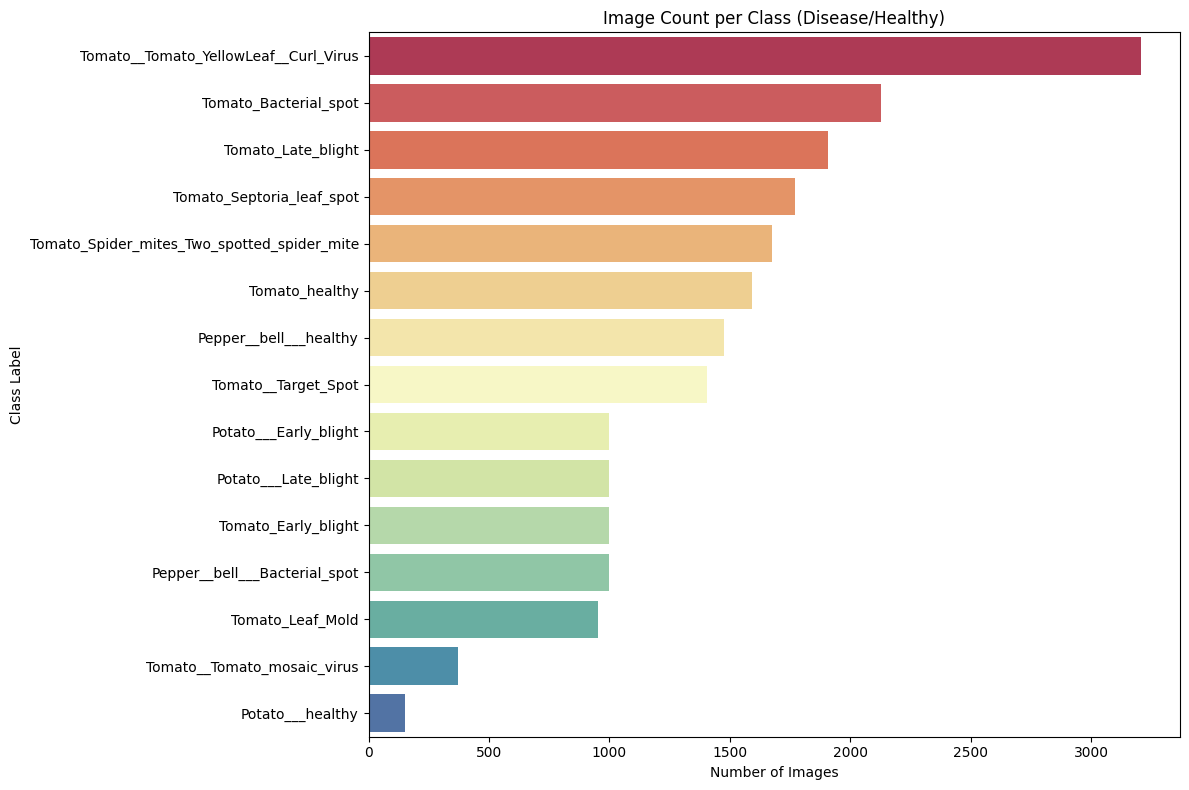

In [7]:
# Class Distribution Plot ---
plt.figure(figsize=(12, 8))
sns.countplot(y='label', data=df1, order=df1['label'].value_counts().index, palette="Spectral")
plt.title("Image Count per Class (Disease/Healthy)")
plt.xlabel("Number of Images")
plt.ylabel("Class Label")
plt.tight_layout()
plt.show()

In [8]:
# --- 2. Image Size and Brightness Analysis ---
sizes = []
brightness = []

print("Analyzing image properties (sample of 3000 images)...")
for path in tqdm(df1['path'].sample(min(3000, len(df1))).tolist()):
    try:
        img = Image.open(path).convert('L')  # convert to grayscale for brightness
        sizes.append(img.size)
        brightness.append(np.mean(np.array(img)))
    except:
        continue

# Convert to DataFrame
sizes_df = pd.DataFrame(sizes, columns=['width', 'height'])
sizes_df['brightness'] = brightness

Analyzing image properties (sample of 3000 images)...



00%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:09<00:00, 329.35it/s]

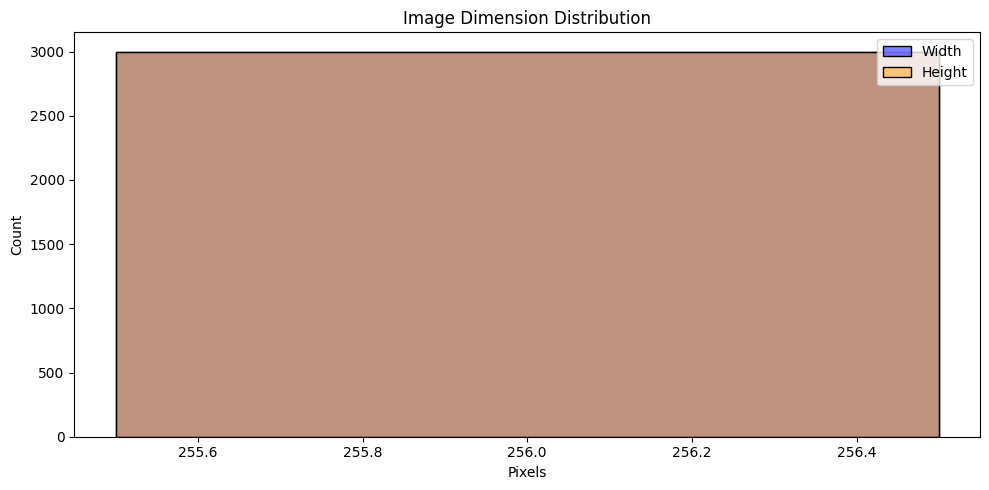

In [9]:
# --- 3. Image Size Distribution ---
plt.figure(figsize=(10, 5))
sns.histplot(sizes_df['width'], color='blue', kde=True, label='Width')
sns.histplot(sizes_df['height'], color='orange', kde=True, label='Height')
plt.title("Image Dimension Distribution")
plt.xlabel("Pixels")
plt.legend()
plt.tight_layout()
plt.show()

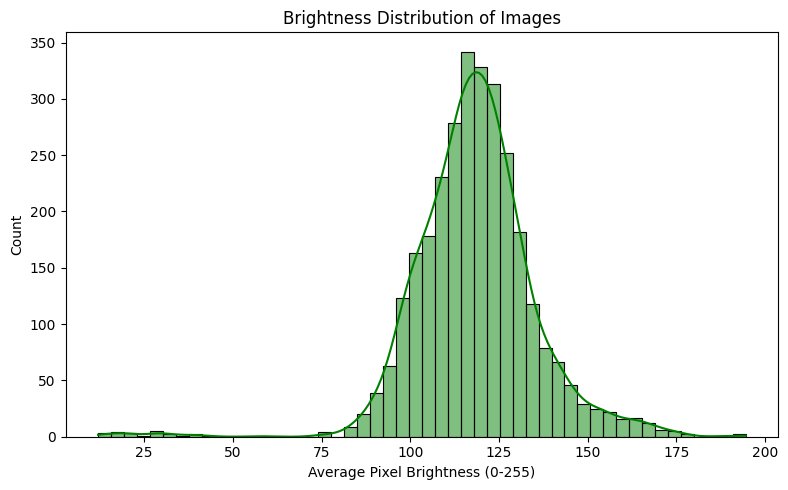

In [8]:
# --- 4. Brightness Distribution ---
plt.figure(figsize=(8, 5))
sns.histplot(sizes_df['brightness'], bins=50, color='green', kde=True)
plt.title("Brightness Distribution of Images")
plt.xlabel("Average Pixel Brightness (0-255)")
plt.tight_layout()
plt.show()

In [14]:
print("Available class labels:")
print(df['label'].unique())

Available class labels:
['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy' 'PlantVillage'
 'Potato___Early_blight' 'Potato___healthy' 'Potato___Late_blight'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_healthy'
 'Tomato_Late_blight' 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_mosaic_virus' 'Tomato__Tomato_YellowLeaf__Curl_Virus']


In [9]:
def show_samples_by_class1(label, num=5):
    class_df = df[df['label'] == label]
    if class_df.empty:
        print(f"No images found for label: {label}")
        return
    samples = class_df.sample(min(num, len(class_df)))
    fig, axes = plt.subplots(1, len(samples), figsize=(15,3))
    for i, (_, row) in enumerate(samples.iterrows()):
        img = Image.open(row['path'])
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(label[:25])
    plt.tight_layout()
    plt.show()

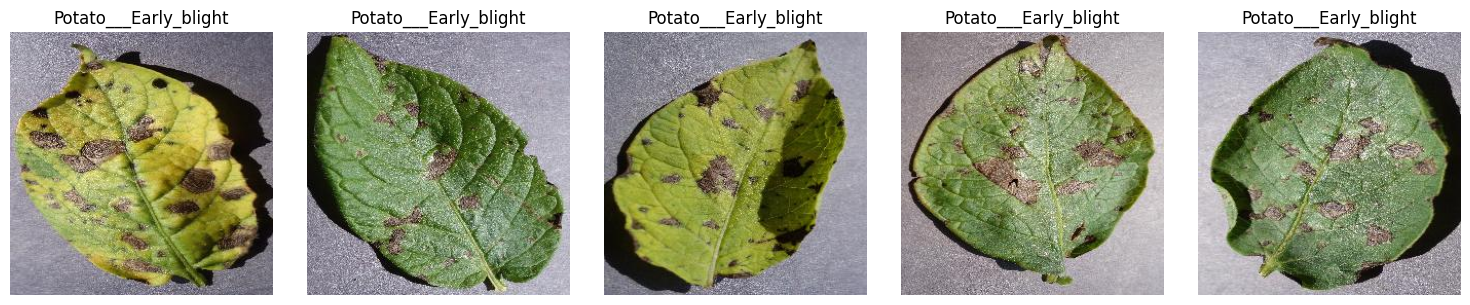

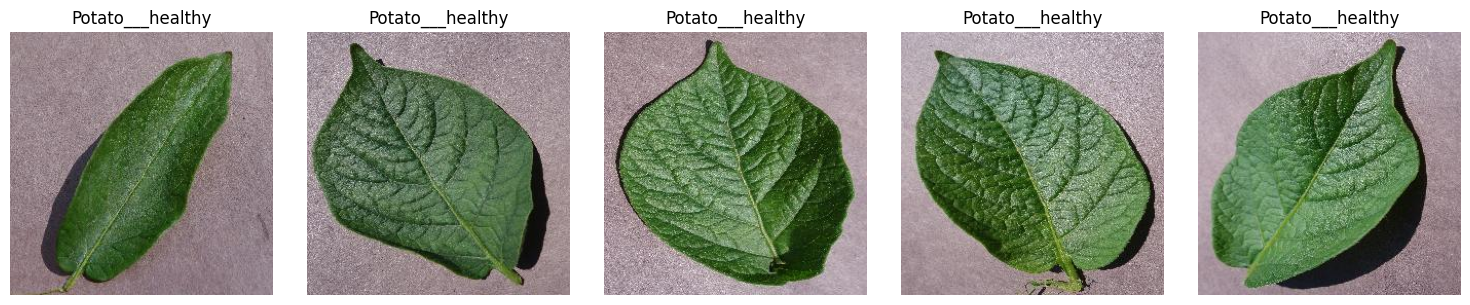

In [10]:
# Show 5 samples from Tomato___Late_blight
show_samples_by_class1('Potato___Early_blight')

# Show 5 samples from Tomato___Healthy
show_samples_by_class1('Potato___healthy')

In [11]:
# --- 6. Summary Statistics ---
print("\n--- Summary Statistics ---")
print(f"Average Brightness: {np.mean(sizes_df['brightness']):.2f}")
print(f"Average Image Width: {np.mean(sizes_df['width']):.0f}px")
print(f"Average Image Height: {np.mean(sizes_df['height']):.0f}px")
print(f"Approximate Dataset Size: ~{round((df.shape[0] * 240) / 1024)} MB (assuming ~240KB per image)")


--- Summary Statistics ---
Average Brightness: 118.34
Average Image Width: 256px
Average Image Height: 256px
Approximate Dataset Size: ~4841 MB (assuming ~240KB per image)


In [34]:
# 2. Create a DataFrame
image_data = []

# Assuming each subfolder name is the label (example: 'Apple___Apple_scab')
for label in os.listdir(dataset_dir):
    label_path = os.path.join(dataset_dir, label)
    if os.path.isdir(label_path):
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            image_data.append({'image_path': image_path, 'label': label})

df = pd.DataFrame(image_data)  # Now you have a proper dataframe!

In [36]:
# Show summary stats
summary_stats = df.describe(include='all')
print(summary_stats)

                                               image_path  \
count                                               20653   
unique                                              20653   
top     C:\Users\Specter\Desktop\Friontier ML training...   
freq                                                    1   

                                        label  
count                                   20653  
unique                                     16  
top     Tomato__Tomato_YellowLeaf__Curl_Virus  
freq                                     3208  


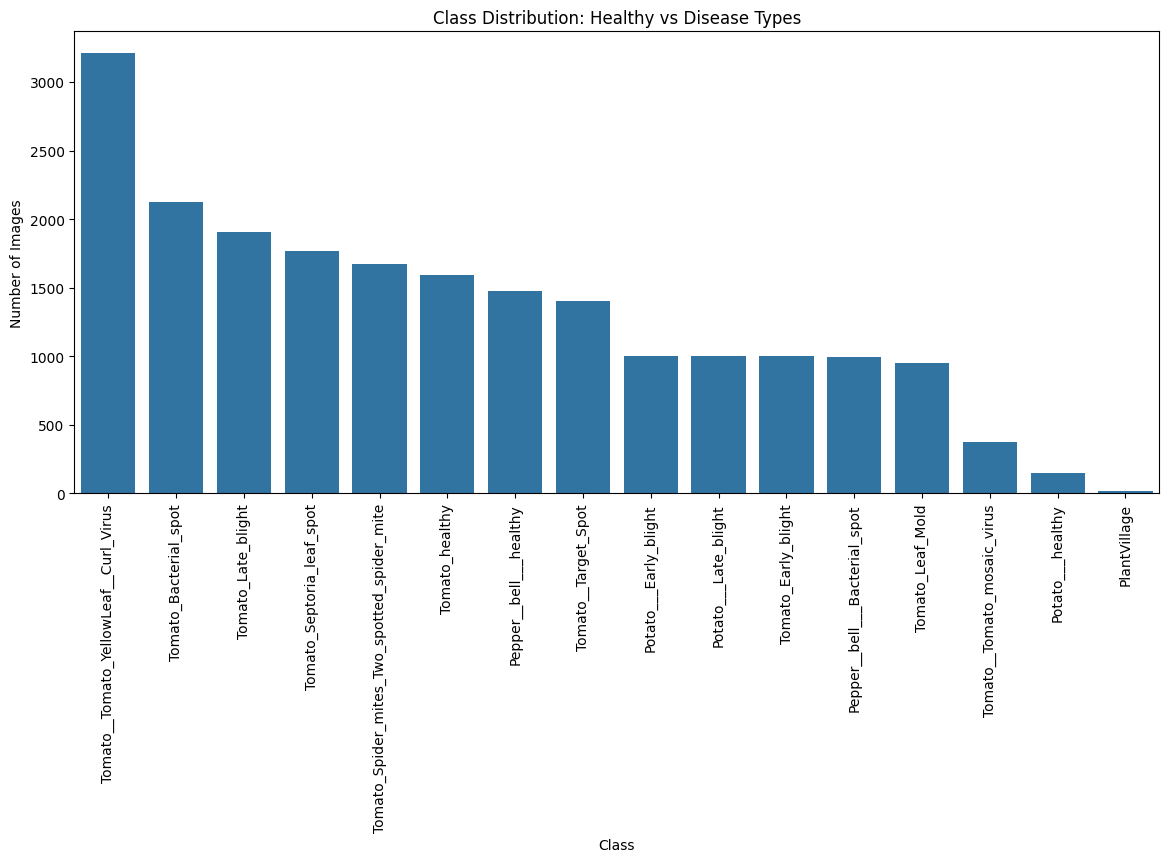

label
Tomato__Tomato_YellowLeaf__Curl_Virus          3208
Tomato_Bacterial_spot                          2127
Tomato_Late_blight                             1909
Tomato_Septoria_leaf_spot                      1771
Tomato_Spider_mites_Two_spotted_spider_mite    1676
Tomato_healthy                                 1591
Pepper__bell___healthy                         1478
Tomato__Target_Spot                            1404
Potato___Early_blight                          1000
Potato___Late_blight                           1000
Tomato_Early_blight                            1000
Pepper__bell___Bacterial_spot                   997
Tomato_Leaf_Mold                                952
Tomato__Tomato_mosaic_virus                     373
Potato___healthy                                152
PlantVillage                                     15
Name: count, dtype: int64


In [37]:
# Bar plot of class counts
plt.figure(figsize=(14,6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Class Distribution: Healthy vs Disease Types')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

# Optional: Show exact counts
class_counts = df['label'].value_counts()
print(class_counts)

In [45]:
import os
from PIL import Image

def get_image_info(img_path):
    if os.path.isfile(img_path):  # Check: is it a file?
        try:
            with Image.open(img_path) as img:
                return img.size, img.mode
        except Exception as e:
            print(f"Error opening {img_path}: {e}")
            return None, None
    else:
        print(f"Not a file: {img_path}")
        return None, None

# Now safely apply it
df['img_size'], df['img_mode'] = zip(*df['image_path'].map(get_image_info))

# Drop rows where loading failed
df = df.dropna(subset=['img_size', 'img_mode'])


Not a file: C:\Users\Specter\Desktop\Friontier ML training\capstone_project\code\data\PlantVillage\PlantVillage\Pepper__bell___Bacterial_spot
Not a file: C:\Users\Specter\Desktop\Friontier ML training\capstone_project\code\data\PlantVillage\PlantVillage\Pepper__bell___healthy
Not a file: C:\Users\Specter\Desktop\Friontier ML training\capstone_project\code\data\PlantVillage\PlantVillage\Potato___Early_blight
Not a file: C:\Users\Specter\Desktop\Friontier ML training\capstone_project\code\data\PlantVillage\PlantVillage\Potato___healthy
Not a file: C:\Users\Specter\Desktop\Friontier ML training\capstone_project\code\data\PlantVillage\PlantVillage\Potato___Late_blight
Not a file: C:\Users\Specter\Desktop\Friontier ML training\capstone_project\code\data\PlantVillage\PlantVillage\Tomato_Bacterial_spot
Not a file: C:\Users\Specter\Desktop\Friontier ML training\capstone_project\code\data\PlantVillage\PlantVillage\Tomato_Early_blight
Not a file: C:\Users\Specter\Desktop\Friontier ML training\ca

In [46]:
df['img_size']

0        (256, 256)
1        (256, 256)
2        (256, 256)
3        (256, 256)
4        (256, 256)
            ...    
20648    (256, 256)
20649    (256, 256)
20650    (256, 256)
20651    (256, 256)
20652    (256, 256)
Name: img_size, Length: 20638, dtype: object

In [42]:
# Let's say we choose one class
target_class = 'Apple___Apple_scab'

# Create two groups: one is the selected class, one is others
df_target = df[df['label'] == target_class]
df_others = df[df['label'] != target_class]

print(f"Number of images in {target_class}: {df_target.shape[0]}")
print(f"Number of images in other classes: {df_others.shape[0]}")


Number of images in Apple___Apple_scab: 0
Number of images in other classes: 20653


C:\Users\Specter\AppData\Local\Temp\ipykernel_15960\2817641999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['total_pixels'] = df['img_size'].apply(lambda x: x[0] * x[1])


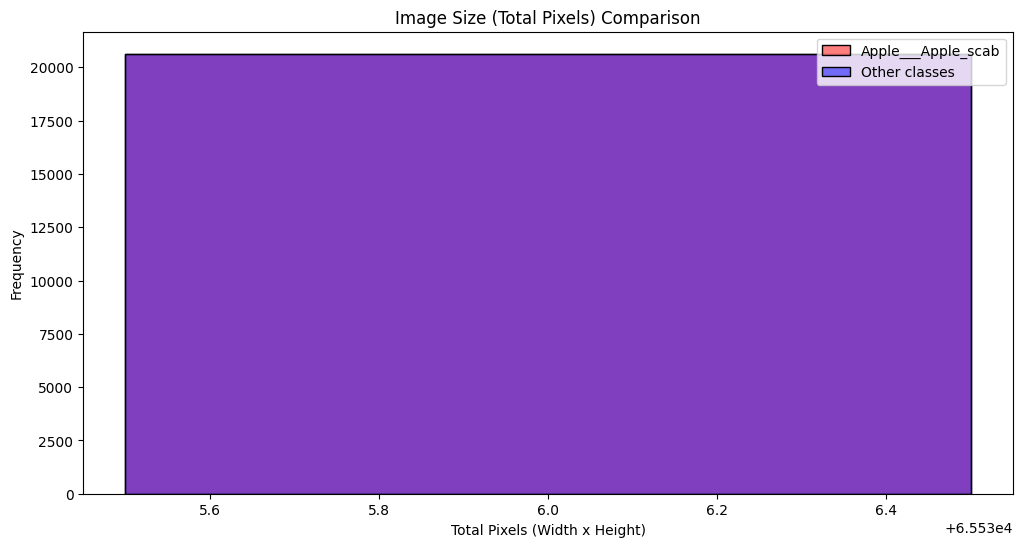

In [49]:
# Extract total pixel count (width * height)
df_target['total_pixels'] = df['img_size'].apply(lambda x: x[0] * x[1])
df_others['total_pixels'] = df['img_size'].apply(lambda x: x[0] * x[1])

# Plot
plt.figure(figsize=(12,6))
sns.histplot(df_target['total_pixels'], color='red', label=target_class, kde=True)
sns.histplot(df_others['total_pixels'], color='blue', label='Other classes', kde=True)
plt.legend()
plt.title('Image Size (Total Pixels) Comparison')
plt.xlabel('Total Pixels (Width x Height)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import random

def plot_random_samples_per_class(data, n_samples=2):
    classes = data['label'].unique()
    num_classes = len(classes)
    
    plt.figure(figsize=(n_samples*3, num_classes*3))
    
    for idx, cls in enumerate(sorted(classes)):
        sample_paths = data[data['label'] == cls]['image_path'].sample(n_samples)
        
        for j, img_path in enumerate(sample_paths):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt_idx = idx * n_samples + j + 1
            plt.subplot(num_classes, n_samples, plt_idx)
            plt.imshow(img)
            plt.axis('off')
            
            if j == 0:
                plt.ylabel(cls, size=12)

    plt.suptitle('Random Samples from Each Class', fontsize=20)
    plt.tight_layout()
    plt.show()

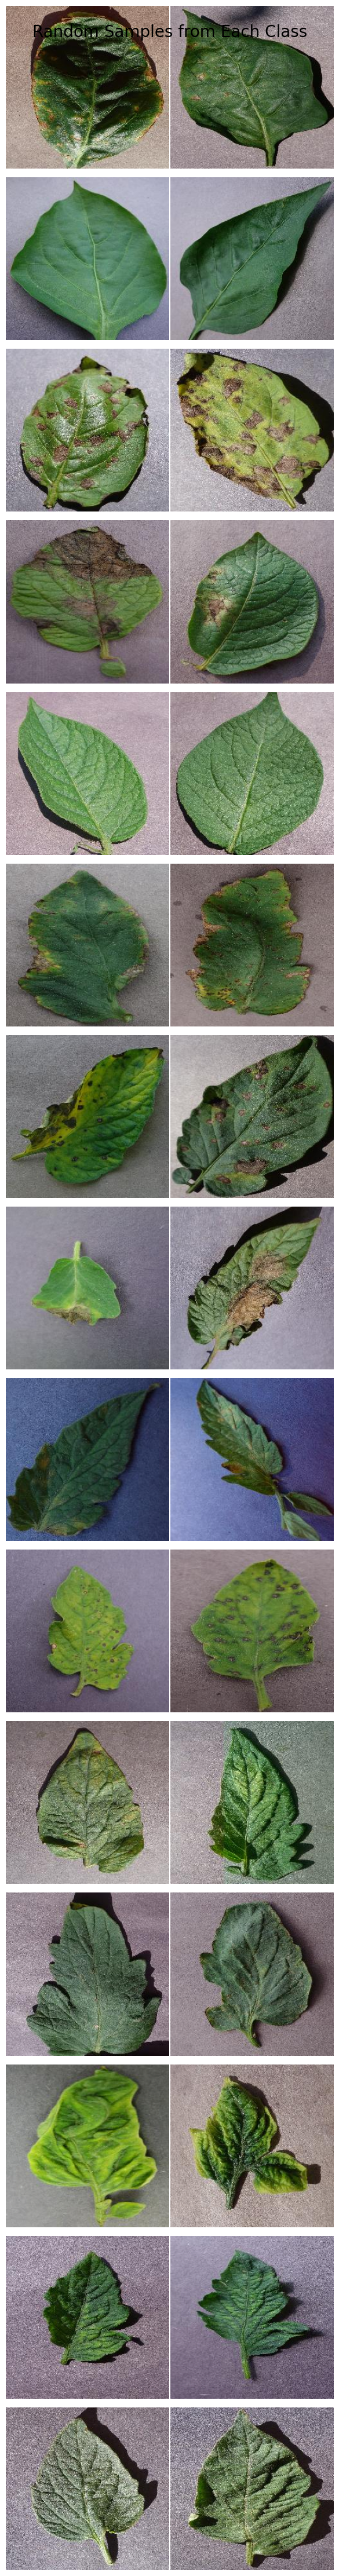

In [53]:
plot_random_samples_per_class(df, n_samples=2)